## PyTorch Basics

Author: Tobias Uelwer

### What is PyTorch?
- PyTorch is a Python Deep Learning library
- Allows us to easily train neural networks, i.e. calculate gradients und update weights
- Developed by Facebook's artificial-intelligence research group
- Works hand in hand with NumPy arrays

(See: https://pytorch.org/ and https://en.wikipedia.org/wiki/PyTorch)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
print(torch.__version__)

1.3.1


In [2]:
# we create a new PyTorch tensor from a NumPy tensor
torch.from_numpy(np.ones((2,2)))
# we can instantanly access its values unlike we are used to from tensorflow

tensor([[1., 1.],
        [1., 1.]], dtype=torch.float64)

In [3]:
# generate a random tensor
A = torch.randn(4,5)
A

tensor([[ 2.0933,  0.6117, -2.2537, -1.4907, -1.5454],
        [ 0.4723, -0.0103,  0.9878,  0.0322, -1.3381],
        [ 0.3862,  0.4862,  0.7080,  1.3480, -0.6752],
        [-0.4018,  2.1530, -0.3331, -0.3856, -1.1122]])

In [4]:
# indexing
A[0,0]

tensor(2.0933)

In [5]:
# more indexing
A[:,2]

tensor([-2.2537,  0.9878,  0.7080, -0.3331])

In [6]:
# get the shape of A
A.shape

torch.Size([4, 5])

In [7]:
# traces and matrix transpose
torch.trace(torch.t(A) @ A)

tensor(26.8895)

In [8]:
# the function item() returns a simple Python scalar
type(torch.sum(A**2))

torch.Tensor

In [9]:
# reshaping
A.view(-1,2,10)

tensor([[[ 2.0933,  0.6117, -2.2537, -1.4907, -1.5454,  0.4723, -0.0103,
           0.9878,  0.0322, -1.3381],
         [ 0.3862,  0.4862,  0.7080,  1.3480, -0.6752, -0.4018,  2.1530,
          -0.3331, -0.3856, -1.1122]]])

In [10]:
# flattens a tensor to a vector
Ones = torch.ones((2,1,9, 1))
Ones.shape, Ones.squeeze().shape

(torch.Size([2, 1, 9, 1]), torch.Size([2, 9]))

In [11]:
# add dimensions
torch.ones(9).unsqueeze(0).shape, torch.ones(9).unsqueeze(1).shape

(torch.Size([1, 9]), torch.Size([9, 1]))

In [12]:
# add new dimensions (this also works with numpy arrays...)
A[None, :, None,:, None].shape

torch.Size([1, 4, 1, 5, 1])

In [13]:
# elementwise power
A**2

tensor([[4.3818e+00, 3.7416e-01, 5.0791e+00, 2.2223e+00, 2.3883e+00],
        [2.2306e-01, 1.0541e-04, 9.7578e-01, 1.0400e-03, 1.7906e+00],
        [1.4913e-01, 2.3634e-01, 5.0130e-01, 1.8172e+00, 4.5586e-01],
        [1.6147e-01, 4.6353e+00, 1.1097e-01, 1.4872e-01, 1.2370e+00]])

In [14]:
# logarithm and absolute value
torch.log(torch.abs(A))

tensor([[ 0.7387, -0.4915,  0.8126,  0.3993,  0.4353],
        [-0.7502, -4.5788, -0.0123, -3.4343,  0.2913],
        [-0.9515, -0.7212, -0.3453,  0.2986, -0.3928],
        [-0.9117,  0.7668, -1.0993, -0.9528,  0.1064]])

In [15]:
# all close
torch.allclose(torch.log(torch.exp(A)), A)

True

In [16]:
torch.log(torch.exp(A))== A

tensor([[ True,  True,  True,  True,  True],
        [ True, False,  True, False,  True],
        [False,  True, False,  True,  True],
        [False,  True, False, False,  True]])

### Automatic differentiation

In [17]:
# if we want to calculate gradients we need to specify this
# by setting requires_grad=True for each tensor
X = torch.ones(2, 2, requires_grad=True)
X

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [18]:
# we build a simple computational graph 
y = torch.sum(torch.exp(X))
y

tensor(10.8731, grad_fn=<SumBackward0>)

In [19]:
# In pytorch gradients are accumulated each time backward() is called.
# Keep that in mind!
y.backward(retain_graph=True) # don't free the graph buffers after backprop
X.grad

tensor([[2.7183, 2.7183],
        [2.7183, 2.7183]])

In [20]:
# to suppress this behavior we have to reset the gradients by
X.grad.zero_()
y.backward(retain_graph=True) # dont free the graph buffers after backprop
X.grad

tensor([[2.7183, 2.7183],
        [2.7183, 2.7183]])

### Optimizing functions

In [21]:
# define variable
x = torch.tensor([2.,2.], requires_grad=True).float()

We want to minimize the function $f(x_1, x_2) = 100(x_2-x_1)^2 + (1-x_1)^2$.

The function has a minimum at $(1,1)$.

In [22]:
# define objective
f = lambda x: 100*(x[1]-x[0]**2)**2+(1-x[0])**2

In [23]:
# instantiate optimizer
opt = torch.optim.Adam([x])

In [24]:
i = 0
while True:
    opt.zero_grad()
    f_val = f(x)
    f_val.backward()
    opt.step()
    i += 1
    if torch.norm(x.grad)<0.001:
        print("Converged after {} iterations.".format(i))
        print("Minimum: {}".format(str(x.detach().numpy())))
        break
    if i>100000:
        print("Maximum number of iterations reached.")
        break

Converged after 15729 iterations.
Minimum: [1.0009778 1.0019593]


## Implementing a linear regression model from scratch

In [25]:
# let's implement a simple linear regression model from scratch
w = torch.randn(2, requires_grad=True)

# generate some data
x = torch.rand(100)
y = x*2 + torch.randn(100)*0.04 +1

# define a simple linear model
def pred(x,w):
    return torch.t(torch.stack([torch.ones(100),x], dim=0))@w

# define mean squared error function
def l2(y,y_pred):
    return (y_pred-y).pow(2).sum()*(1/len(y_pred))

# loss history
h = []

# apply gradient descent updates to w
lr = 0.1
for k in range(500):
    
    y_pred = pred(x,w)
    loss = l2(y_pred, y)
    loss.backward()
    h += [loss.item()]
    if k % 50 == 0:
        print(h[-1])
        
    w.data = w.data -(lr*w.grad)
    w.grad.zero_()    

15.361172676086426
0.0014929436147212982
0.00149244733620435
0.0014923119451850653
0.0014922742266207933
0.0014922652626410127
0.0014922613045200706
0.0014922615373507142
0.0014922613045200706
0.0014922606060281396


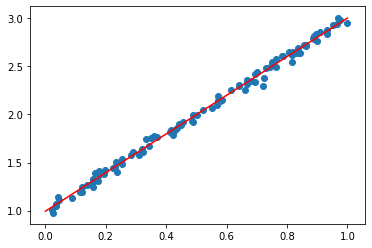

In [26]:
x_plot = torch.linspace(0,1)
plt.scatter(x,y)
plt.plot(x_plot.numpy(), pred(x_plot,w).detach().numpy(), 'r')

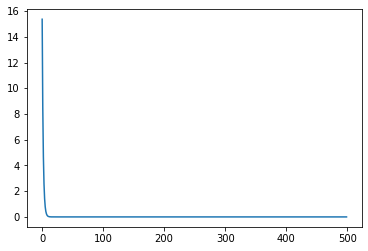

In [27]:
plt.plot(h);

In [28]:
w

tensor([0.9936, 2.0087], requires_grad=True)

## Implementing a linear regression model - simpler way

In [29]:
# generate some data
x = torch.rand(100)
y = x*2 + torch.randn(100)*0.04

In [30]:
x = x.unsqueeze(1)
y = y.unsqueeze(1)

In [31]:
from torch import nn
from torch import optim

In [32]:
model = nn.Linear(in_features=1, out_features=1) # define model

criterion = nn.MSELoss() # instantiate loss 

optimizer = optim.Adam(model.parameters(), lr=0.1) # instantiate optimizer

In [33]:
for k in range(0, 500):
    # set the parameter gradients to zero
    optimizer.zero_grad()

    # forward pass
    outputs = model(x)
        
    # training loss
    loss = criterion(outputs, y)
    
    if k % 50 == 0:
        print(loss.item())
        
    # backward pass
    loss.backward()
    optimizer.step()

0.2700481712818146
0.0026580756530165672
0.0013917061733081937
0.0013886207016184926
0.0013886167434975505
0.0013886160450056195
0.0013886166270822287
0.0013886165106669068
0.0013886166270822287
0.0013886166270822287


In [34]:
list(model.parameters())

[Parameter containing:
 tensor([[1.9922]], requires_grad=True), Parameter containing:
 tensor([0.0092], requires_grad=True)]

## Fitting a neural network regression model

In [35]:
# generate some more complicated data
x = 20*torch.rand(100)
y = torch.sin(x) + torch.randn(100)*0.04

In [36]:
x = x.unsqueeze(1)
y = y.unsqueeze(1)

In [37]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=200),
    nn.Tanh(),
    nn.Linear(in_features=200, out_features=1)
) # define model

criterion = nn.MSELoss() # instantiate loss 

optimizer = optim.Adam(model.parameters()) # instantiate optimizer

In [38]:
for k in range(0, 10000):
    # set the parameter gradients to zero
    optimizer.zero_grad()

    # forward pass
    outputs = model(x)
        
    # training loss
    loss = criterion(outputs, y)
    
    if k % 500 == 0:
        print(loss.item())
        
    # backward pass
    loss.backward()
    optimizer.step()

0.6527833342552185
0.3643264174461365
0.3463611602783203
0.33593878149986267
0.3232927918434143
0.3049491345882416
0.283927857875824
0.22613145411014557
0.1554427444934845
0.10180167853832245
0.06490174680948257
0.03803000971674919
0.021298686042428017
0.011413037776947021
0.006340168882161379
0.00404977984726429
0.003032884793356061
0.002589214127510786
0.002390469191595912
0.0022968605626374483


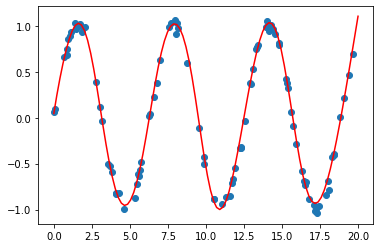

In [39]:
x_plot = torch.linspace(0,20)[:,None]
plt.scatter(x,y)
plt.plot(x_plot.numpy(), model(x_plot).detach().numpy(), 'r');